In [ ]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

     |████████████████████████████████| 274 kB 8.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=2d0b6a00238951d59262667a02ad22c3248748385f837a81e7bfbb0c7379bf6d
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.10.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 5.9 MB/s 
     |████████████████████████████████| 49 kB 4.3 MB/s 
     |████████████████████████████████| 130 kB 14.7 MB/s 
     |████████████████████████████████| 145 kB 53.9 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 749 kB 46.5 MB/s 
     |████████████████████████████████| 843 kB 46.9 MB/s 
     |████████████████████████████████| 112 kB 56.0 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=1bc317a02a46bac53d4b1929930e128c9c336e674207b11134baf08a550253f3
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=430af73ed558b262719617990bb1c60ae0dde61e5eb8534ae0f424ab7d527e

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import glob
import json

import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms as T
from PIL import Image
from tqdm import tqdm



#from detectron2.structures import BoxMode
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IN_COLAB = False
# def mount_data_from_drive():
#   try:
#     import google.colab
#     IN_COLAB = True
#   except:
#     IN_COLAB = False

#   if(IN_COLAB):
# from google.colab import drive
# drive.mount('/content/drive')
!unzip -qq '/content/drive/MyDrive/release_ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21.zip'

  

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ffoenbvz
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ffoenbvz
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5722946 sha256=0adfd8415757e7e9765d8c4f563ebdb4bc0b7244a2c98eeff9e7c13222fc0b05
  Stored in directory: /tmp/pip-ephem-wheel-cache-74fgulor/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
Successfully built detectron2
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu101
    Uninstalling detectron2-0.6+cu101:
      Successfully uninstalled detectron2-0.6+cu101


In [ ]:
# if(IN_COLAB):
#   !unzip -qq '/content/drive/MyDrive/release_ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21.zip'
#   downloaded = True


In [ ]:
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html


from detectron2.structures import BoxMode

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html


In [ ]:
BASE_DIR = '/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/'
image_dir = BASE_DIR+'images/'
json_dir = BASE_DIR + 'annotations_JSON/'


In [ ]:
def check_valid_json(json_data, chart_type):

  if(json_data):
    if not ('task6'in json_data):
      return False
    if ('task6'in json_data):
      val = json_data['task6']
      #print(val)
      if(val is None):
        return False
      else:
        val = json_data['task6']['output']['visual elements']
        if(chart_type == 'horizontal_bar'):
          if('bar' in val):
            val = json_data['task6']['output']['visual elements']['bar']
            for box in val:
              if(box['height']<=0):
                return False
              elif(box['width']<=0):
                return False
        #   else:
        #     return False
        # else:
        #   return False
        
        # elif(chart_type == 'vertical_bar'):
        #   if('boxplot' in val):
        #     return True
  return True


In [ ]:
def get_paths_dataframe_box(charts ,root_dir,json_dir):
  paths_pd_train = {} 
  paths_pd_val = {}#pd.DataFrame()
  img_list = []
  json_list = []
  img_path = []
  json_path = []
  single_bbox_data = []
  image_ids = []

  model_input = []
  for i in charts:
    path = root_dir + i
    img_list = sorted(os.listdir(path))
    json_p = json_dir + i
    json_list = sorted(os.listdir(json_p))
    for j,k in zip(img_list,json_list):
      # fi = image_path
      json_fd = open(json_p + '/' + k)
      json_data = json.load(json_fd)
      #print(json_p + '/' + k)
      if(check_valid_json(json_data, i)):
        json_single_path = json_p + '/' + k
        img_single_path = path + '/' + j
        #if(json_data['task6']!='Null'):
        img_path.append(img_single_path)
        json_path.append(json_single_path)
        json_fd = open(json_single_path)
        json_data = json.load(json_fd)
        # bboxes = get_bounding_box_gt(json_data)
        # if not bboxes:
        #   print (json_data['task6']['input']['task1_output']['chart_type'])
        #   print("no bboc found in file ", json_single_path)
        # else:
        #   for bb in bboxes:
        #     model_input.append([img_single_path, bb, j])
        image_ids.append(j)
  
  total_items = len(img_path)
  train_img_path = img_path[0: int(0.8*total_items)]
  val_img_path = img_path[int(0.8*total_items):-1]

  train_json_path = json_path[0: int(0.8*total_items)]
  val_json_path = json_path[int(0.8*total_items):-1]

  train_image_ids = image_ids[0: int(0.8*total_items)]
  val_image_ids = image_ids[int(0.8*total_items):-1]

  paths_pd_train['images'] = train_img_path 
  paths_pd_train['json'] = train_json_path
  paths_pd_train['image_ids'] = train_image_ids

  paths_pd_val['images'] = val_img_path 
  paths_pd_val['json'] = val_json_path
  paths_pd_val['image_ids'] = val_image_ids
  #paths_pd['input'] = model_input
  #print(len(img_path))
  #print(len(json_path))
  return paths_pd_train,paths_pd_val

In [ ]:
def get_paths_dataframe_point(charts ,root_dir,json_dir):
  paths_pd_train = {} #pd.DataFrame()
  img_list = []
  json_list = []
  img_path = []
  json_path = []
  single_bbox_data = []
  model_input = []
  for i in charts:
    path = root_dir + i
    img_list = sorted(os.listdir(path))
    json_p = json_dir + i
    json_list = sorted(os.listdir(json_p))
    for j,k in zip(img_list,json_list):
      # fi = image_path
      json_fd = open(json_p + '/' + k)
      json_data = json.load(json_fd)
      #print(json_p + '/' + k)
      
      if(check_valid_json(json_data, i)):

        json_single_path = json_p + '/' + k
        img_single_path = path + '/' + j
        #if(json_data['task6']!='Null'):
        img_path.append(img_single_path)
        json_path.append(json_single_path)
        json_fd = open(json_single_path)
        json_data = json.load(json_fd)
        points = get_points(json_data)
        if not points:
          print (json_data['task6']['input']['task1_output']['chart_type'])
          print("no points found in file ", json_single_path)
        else:
          for point in points:
            model_input.append([img_single_path, point, j])
  
  paths_pd['images'] = img_path 
  paths_pd['json'] = json_path
  paths_pd['input'] = model_input
  #print(len(img_path))
  #print(len(json_path))
  return paths_pd

In [ ]:
def get_points(input):
  points = []
  for each_item in input:
    class_no = 0
    for point in each_item:
      x= point[0]
      y = point[1]
      class_no += 1
      points.append([x,y,class_no])

  return points




In [ ]:
def get_points_gt(input):
  if(input['task6']['input']['task1_output']['chart_type'] == "lines"):
    return get_points(input['task6']['output']['visual elements']['line'])
  elif(input['task6']['input']['task1_output']['chart_type'] == "scatter"):
    return get_points(input['task6']['output']['visual elements']['scatter points'])


In [ ]:
def get_bb_horizontal_box(input , image_new_size, image_old_size ):
  
  bb_boxes = []
  areas = []
  for x in input:
    height = x['height']
    width = x['width']
    xmin = x['x0']
    ymin = x['y0']
    xmax = xmin + width
    ymax = ymin + height
       

    old_width, old_height = image_old_size[0],image_old_size[1]
    new_width, new_height = image_new_size[0],image_new_size[1]
    #print(old_width, old_height)
    #print(new_width, new_height)
    xmin_new = int((xmin/old_width)*new_width)
    ymin_new = int((ymin/old_height)*new_height)
    xmax_new = int((xmax/old_width)*new_width) +1
    ymax_new = int((ymax/old_height)*new_height) + 1

    #if(xmin_new==xmax_new or ymin_new==ymax_new):
      #print("error in bounding box : width {} height {}".format(xmin_new,xmax_new))
      
    #print(" read values", [xmin,ymin,width,height])
    #print([xmin_new,ymin_new,xmax_new,ymax_new])
    class_no = 0
    bb_boxes.append([xmin_new,ymin_new,xmax_new,ymax_new])
    area = (xmax_new-xmin_new) * (ymax_new-ymin_new)
    areas.append(area)
  
  return bb_boxes, areas


In [ ]:
def get_bb_vertical_box(input , image_new_size, image_old_size):
  bb_boxes = []
  areas = []
  #print("here in vb")
  element_types = ["first_quartile","max", "median", "min", "third_quartile" ]
  for element in input:
    i = 0
     
    height =  element["first_quartile"]['_bb']['y0'] - element["third_quartile"]['_bb']['y0']
    width = element["third_quartile"]['_bb']['width']
    xmin = element["third_quartile"]['_bb']['x0']
    ymin = element["third_quartile"]['_bb']['y0']
    xmax = xmin + width
    ymax = ymin + height

    old_width, old_height = image_old_size[0],image_old_size[1]
    new_width, new_height = image_new_size[0],image_new_size[1]
    xmin_new = (xmin/old_width)*new_width
    ymin_new = (ymin/old_height)*new_height
    xmax_new = (xmax/old_width)*new_width
    ymax_new = (ymax/old_height)*new_height
    #print(" read values", [xmin,ymin,width,height])
    #print([xmin_new,ymin_new,xmax_new,ymax_new])
    class_no = 0
    bb_boxes.append([xmin_new,ymin_new,xmax_new,ymax_new])
    area = (xmax_new-xmin_new) * (ymax_new-ymin_new)
    areas.append(area)
  
  return bb_boxes, areas


In [ ]:
def get_bounding_box_gt(input, image_new_size, image_old_size):

  if(input['task6']['input']['task1_output']['chart_type'] == "vertical box"):
    return get_bb_vertical_box(input['task6']['output']['visual elements']['boxplots'] , image_new_size, image_old_size)
  if(input['task6']['input']['task1_output']['chart_type'] == "horizontal bar"):
    return get_bb_horizontal_box(input['task6']['output']['visual elements']['bars'], image_new_size, image_old_size)

In [ ]:
class ChartDataset(Dataset):
  def __init__(self,paths, mode = 'box', image_size =416,transforms = None):
    self.image_path= paths['images']
    self.image_ids = paths['image_ids']
    #self.extracted_data = paths['input']
    #print(self.image_path)
    self.json_path = paths['json'] 
    # self.to_tensor = torchvision.transforms.ToTensor()
    self.data_len = len(self.image_path)
    print(self.data_len)
    self.transforms = transforms
    self.num_samples = self.data_len
    self.mode = mode


  def __getitem__(self, index):
  #   if(self.mode == 'box'):
  #     return self.getitem_box(self,index)
  #   if(self.mode == 'point'):
  #     return self.getitem_point(self,index)
    

  # # def getitem_point(index):
  #   pass


  # def getitem_box(index):
    
    single_image_name = self.image_path[index]

    #print(single_image_name)
    
    image = Image.open(single_image_name)
    image = image.convert("RGB")
    # if self.transforms:
    #   img_as_img = self.transforms(img_as_img)
    # image = cv2.imread(single_image_name,cv2.IMREAD_COLOR)
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # image= image/255.0
    image_old_size = image.size
    #print(image_old_size)
    if self.transforms:
      image = self.transforms(image)

    image_new_size = image.size()
    #print(image_new_size)
    #img_height = image.shape[0]

    json_fd = open(self.json_path[index])
    #print(self.json_path[index])
    json_data = json.load(json_fd)
    #print(json_data)

    bboxes, areas = get_bounding_box_gt(json_data, image_new_size, image_old_size)
    
    #check later to handle this case
    #if not bboxes:
    #   print (json_data['task6']['input']['task1_output']['chart_type'])
      #print("no bbox found in file ", json_single_path)
    # else:
    #   for bb in bboxes:
    #     bboxes.append(bb)

    bboxes = torch.as_tensor(bboxes,dtype = torch.float32)
    areas = torch.as_tensor(areas,dtype = torch.float32)
    labels = torch.ones((bboxes.shape[0],),dtype = torch.int64)
    iscrowd = torch.zeros((bboxes.shape[0],),dtype = torch.int64)
    #print(self.image_ids[index], index)
    target = {}
    target['boxes'] = bboxes
    target['labels'] = labels
    target['area'] = areas
    target['image_id'] = torch.tensor([index])
    target['iscrowd'] = iscrowd
    #print(type(image))
    

    #image = torchvision.transforms.ToTensor()(image)
    
    return image, target 

  def __len__(self):
    return self.data_len

In [ ]:
# def get_balloon_dicts(img_dir):
#     json_file = os.path.join(img_dir, "via_region_data.json")
#     with open(json_file) as f:
#         imgs_anns = json.load(f)

#     dataset_dicts = []
#     for _, v in imgs_anns.items():
#         record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
#         height, width = cv2.imread(filename).shape[:2]
        
#         record["file_name"] = filename
#         record["height"] = height
#         record["width"] = width
      
#         annos = v["regions"]
#         objs = []
#         for _, anno in annos.items():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             #print("poly1", poly)
#             poly = list(itertools.chain.from_iterable(poly))
#             #print("poly2", poly)
#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": 0,
#                 "iscrowd": 0
#             }
#             print(obj["segmentation"])
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

# from detectron2.data import DatasetCatalog, MetadataCatalog
# for d in ["train"]:
#     #DatasetCatalog.register("balloon/" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     print(get_balloon_dicts(("balloon/" + d)))
#     #MetadataCatalog.get("balloon/" + d).set(thing_classes=["balloon"])
# #balloon_metadata = MetadataCatalog.get("balloon/train")





In [ ]:
# write a function that loads the dataset into detectron2's standard format

def get_charts_dicts(paths):
  image_paths = paths['images']
  json_paths = paths['json']
  image_ids = paths['image_ids']

  dataset_dicts = []

  for image_path,json_path, image_id in zip(image_paths, json_paths, image_ids):
    
    image = Image.open(image_path)
    image = image.convert("RGB")
    width, height = image.size

    json_fd = open(json_path)
    json_data = json.load(json_fd)

    record = {}
    record["file_name"] = image_path
    record["height"] = height
    record["width"] = width
    objs = []
    bboxes = get_bounding_box_gt(json_data, image.size, image.size)
    for box in bboxes[0]: 
      poly = [box[0], box[1], box[2], box[1], box[2], box[3], box[0], box[3]]
      obj = {
          "bbox":box,
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": [poly],
          "category_id": 0,
          "iscrowd": 0
      }
      objs.append(obj)
      
    record["annotations"] = objs
    dataset_dicts.append(record)

  return dataset_dicts


In [ ]:
box_detector_folders = ["horizontal_bar", "vertical_box" ]
paths_Train, paths_Val = get_paths_dataframe_box(box_detector_folders,image_dir,json_dir)


In [ ]:
from detectron2.data import DatasetCatalog
for d in ["Train"]:
    DatasetCatalog.register("Chart_Dataset_" + d ,  lambda d=d:get_charts_dicts(paths_Train))

for d in ["Val"]:
    DatasetCatalog.register("Chart_Dataset_" + d ,  lambda d=d:get_charts_dicts(paths_Val))

from detectron2.data import  MetadataCatalog
# for d in ["train"]:
#     #DatasetCatalog.register("balloon/" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
#     print(get_balloon_dicts(("balloon/" + d)))
MetadataCatalog.get("Chart_Dataset_Val").set(thing_classes=["Bars"])
chart_Test_metadata = MetadataCatalog.get("Chart_Dataset_Val")


AssertionError: ignored

In [ ]:
print(get_charts_dicts(paths_Train))

[{'file_name': '/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/horizontal_bar/PMC1326229___1471-2350-6-43-3.jpg', 'height': 368, 'width': 600, 'annotations': [{'bbox': [115, 66, 207, 99], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[115, 66, 207, 66, 207, 99, 115, 99]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [115, 144, 186, 177], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[115, 144, 186, 144, 186, 177, 115, 177]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [115, 220, 499, 254], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[115, 220, 499, 220, 499, 254, 115, 254]], 'category_id': 0, 'iscrowd': 0}]}, {'file_name': '/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/horizontal_bar/PMC1326229___1471-2350-6-43-6.jpg', 'height': 438, 'width': 600, 'annotations': [{'bbox': [129, 74, 130, 109], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[129, 74, 130, 74, 130, 109, 129, 109]], 'category_id': 0, 'iscrowd': 0}, {'bbox': [129, 159, 188, 193], 'bbox

In [ ]:
import gc
torch.cuda.empty_cache()
cfg = None
trainer = None
gc.collect()

8298

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_1x.yaml"))
cfg.MASK_ON = False
#print(cfg)

cfg.DATASETS.TRAIN = ("Chart_Dataset_Train",)
# cfg.DATASETS.TEST = ("Chart_Dataset_Val",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
#TBD
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_   /137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 14000   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
print(cfg.SOLVER.STEPS)
print(cfg.SOLVER.STEPS)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

(60000, 80000)
(60000, 80000)
[12/19 05:00:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(

FileNotFoundError: ignored

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


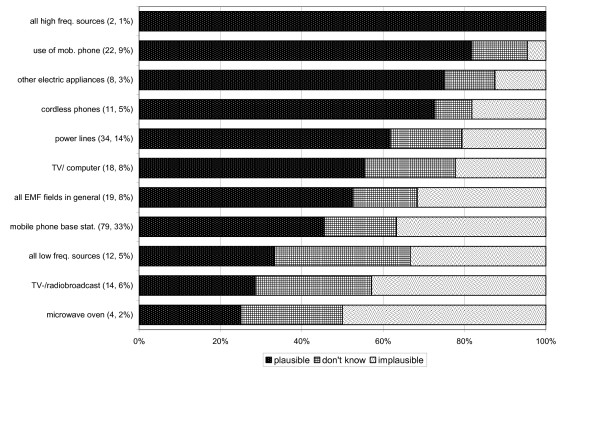

{'instances': Instances(num_instances=25, image_height=424, image_width=600, fields=[pred_boxes: Boxes(tensor([[150.1139,  12.3425, 554.7359,  31.2983],
        [127.8274, 185.9915, 391.2021, 207.7339],
        [131.1061,  69.2055, 473.1256,  90.9884],
        [358.7375, 274.7208, 537.4318, 296.0273],
        [134.4880, 216.5693, 334.0926, 237.0490],
        [128.7324,  40.4101, 523.3897,  60.5759],
        [131.7560, 157.3160, 409.5631, 178.6297],
        [140.3545, 127.2311, 410.1530, 149.6891],
        [405.0919, 187.7139, 531.0613, 207.8626],
        [399.2193, 216.5714, 540.8239, 234.3822],
        [329.3288, 302.4251, 543.9990, 325.1201],
        [133.1034, 245.9936, 339.0053, 266.9549],
        [411.7517, 246.4423, 539.2366, 267.0732],
        [134.7312, 274.8888, 357.6995, 295.0599],
        [137.0311, 303.4178, 330.2009, 325.6607],
        [126.2240,  99.1124, 437.2672, 120.5903],
        [455.0793, 159.0741, 538.7673, 178.0576],
        [444.6557, 127.8998, 532.5303, 146.0470

In [ ]:
#test_image = cv2.imread('/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/horizontal_bar/PMC1449883___pgen.0020024.g008', cv2.IMREAD_COLOR)
image_name = "/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/horizontal_bar/PMC1635563___1471-2458-6-267-2.jpg"
img = cv2.imread(image_name, cv2.IMREAD_COLOR)
from google.colab.patches import cv2_imshow
cv2_imshow(img)
output = predictor(img)
print(output)

In [ ]:
import json

In [ ]:
pred_path = '/content/drive/MyDrive/pred_output/'

#Final Json Conversion

In [ ]:
# image_name = "/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/images/horizontal_bar/PMC1635563___1471-2458-6-267-2.jpg"
def build_test_json(test_images, pred_path):

  for image_name in test_images:
    img = cv2.imread(image_name, cv2.IMREAD_COLOR)
    output = predictor(img)
    imu = image_name.split('/')
    chart_type = imu[-2]
    image_na = imu[-1]
    dirName = pred_path + chart_type
    #print(dirName)
    if not os.path.exists(dirName):
      os.makedirs(dirName)
    image_na_split = image_na.split('.')
    image_na_split_right = image_na_split[0]
    final_json = dirName + '/' + image_na_split_right + '.json'
    x = output['instances'].pred_boxes
    a=x.tensor.cpu()
    a=a.numpy()
    input = {}
    input['task6'] = {}
    input['task6']['output'] ={}
    input['task6']['output']['visual elements'] = {}
    input['task6']['output']['visual elements']['bars']=[]
    for i in a:
      if chart_type == 'horizantal_bar':
        main_box = {}
        main_box['height'] = int(i[3])-int(i[1])
        main_box['width'] = int(i[2])-int(i[0])
        main_box['x0'] = int(i[0])
        main_box['y0'] = int(i[1])
        input['task6']['output']['visual elements']['bars'].append(main_box)

    with open(final_json, 'w') as f:
        json.dump(input, f)


In [ ]:
build_test_json(paths_Val["images"], pred_path)

In [ ]:
import os
import sys
import json
import math
import itertools
import editdistance
import numpy as np
import scipy.optimize
import scipy.spatial.distance

def check_groups(ds):
    try:
        _i = ds[0][0]
        return 1
    except Exception:
        return 0

def pprint(obj):
    print(json.dumps(obj, indent=4, sort_keys=True))

def get_dataseries(json_obj):
    if 'task6_output' in json_obj:
        return json_obj['task6_output']['visual elements']
    elif 'task6' in json_obj:
        return json_obj['task6']['output']['visual elements']
    return None

def euclid(p1, p2):
    x1 = float(p1['x'])
    y1 = float(p1['y'])
    x2 = float(p2['x'])
    y2 = float(p2['y'])
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# def box_to_discrete(ds):
#     out = []
#     for it_name in ['first_quartile', 'max', 'min', 'median', 'third_quartile']: 
#         out.append( {'name': it_name, 'x': ds[it_name]['x'], 'y': ds[it_name]['y']} )
#     return out

def box_arr_to_np(ds):
    n = np.zeros( (1, 8))
    cnt_q = 0
    for _i,p in enumerate(ds):      
        n[0,cnt_q] = float(ds[p]['y'])
        n[0,cnt_q+1] = float(ds[p]['x'])
        cnt_q = cnt_q+1
    return n

def compare_box(pred_ds, gt_ds, min_dim):
    pred_ds = box_arr_to_np(pred_ds)
    gt_ds = box_arr_to_np(gt_ds)
    cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_ds, gt_ds, metric='cityblock') /(min_dim*0.05))
    return cost_mat

def scatt_arr_to_np(ds):
    n = np.zeros((len(ds), 2))
    for i, p in enumerate(ds):
        n[i,0] = float(p['x'])
        n[i,1] = float(p['y'])
    return n

def bar_arr_to_np(ds):
    n = np.zeros([1,4])
    n[0,0] = float(ds['y0'])
    n[0,1] = float(ds['x0'])
    n[0,2] = float(ds['height']) + float(ds['y0'])
    n[0,3] = float(ds['width']) + float(ds['x0'])
    return n

def compare_bar(pred_ds, gt_ds, min_dim):
    pred_ds = bar_arr_to_np(pred_ds)
    gt_ds = bar_arr_to_np(gt_ds)
    
    cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_ds, gt_ds, metric='cityblock') /(min_dim*0.05))
    return cost_mat

def compare_scatter(pred_ds, gt_ds, min_dim, gamma, beta):

    is_grouped = check_groups(gt_ds)
    
    if is_grouped:
        len_seq = len(gt_ds)
    else:
        len_seq = 1
        pred_ds = [pred_ds]
        gt_ds = [gt_ds]

    score = np.zeros((len(gt_ds), len(pred_ds)))
    for iter_seq1 in range(len(gt_ds)):
        gt_seq = scatt_arr_to_np(gt_ds[iter_seq1])

        for iter_seq2 in range(len(pred_ds)):
            pred_seq = scatt_arr_to_np(pred_ds[iter_seq2])
        
            # V = np.cov(gt_ds.T)
            # VI = np.linalg.inv(V).T
            
            #cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_ds, gt_ds, metric='mahalanobis', VI=VI) / gamma)
            cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_seq, gt_seq, metric='euclidean') / (min_dim*gamma))
        
            score[iter_seq1, iter_seq2] = get_score(cost_mat)

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-score)
    score = score[row_ind, col_ind].sum()/(float(len(gt_ds))*beta)

    return score

def get_score(cost_mat):
    cost_mat = pad_mat(cost_mat)
    k = cost_mat.shape[0]
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_mat)
    
    cost = cost_mat[row_ind, col_ind].sum()
    score = 1 - (cost / k)
    return score

def get_cont_recall(p_xs, p_ys, g_xs, g_ys, epsilon):
    total_score = 0
    total_interval = 0

    for i in range(g_xs.shape[0]):
        x = g_xs[i]
        
        if g_xs.shape[0] == 1:
            interval = 1
        elif i == 0:
            interval = (g_xs[i+1] - x) / 2
        elif i == (g_xs.shape[0] - 1):
            interval = (x - g_xs[i-1]) / 2
        else:
            interval = (g_xs[i+1] - g_xs[i-1]) / 2

        y = g_ys[i]
        y_interp = np.interp(x, p_xs, p_ys)
        error = min(1, abs( (y - y_interp) / (abs(y) + epsilon)))
        total_score += (1 - error) * interval
        total_interval += interval

    if g_xs.shape[0] != 1:
        assert np.isclose(total_interval, g_xs[-1] - g_xs[0])
    return total_score / total_interval

def compare_continuous(pred_ds, gt_ds):
    pred_ds = sorted(pred_ds, key=lambda p: float(p['x']))
    gt_ds = sorted(gt_ds, key=lambda p: float(p['x']))

    if not pred_ds and not gt_ds:
        # empty matches empty
        return 1.0
    elif not pred_ds and gt_ds:
        # empty does not match non-empty
        return 0.0
    elif pred_ds and not gt_ds:
        # empty does not match non-empty
        return 0.0

    p_xs = np.array([float(ds['x']) for ds in pred_ds])
    p_ys = np.array([float(ds['y']) for ds in pred_ds])
    g_xs = np.array([float(ds['x']) for ds in gt_ds])
    g_ys = np.array([float(ds['y']) for ds in gt_ds])

    epsilon = (g_ys.max() - g_ys.min()) / 100.
    recall = get_cont_recall(p_xs, p_ys, g_xs, g_ys, epsilon)
    precision = get_cont_recall(g_xs, g_ys, p_xs, p_ys, epsilon)

    return (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.

def norm_edit_dist(s1, s2):
    return editdistance.eval(s1, s2) / float(max(len(s1), len(s2), 1))

def create_dist_mat(pred_seq, gt_seq, compare, beta):
    is_grouped = check_groups(gt_seq)

    if not is_grouped:
        len_seq = 1
        gt_seq = [gt_seq]
        pred_seq = [pred_seq]

    score = 0
    for iter_seq1 in range(len(gt_seq)):
        l1 = len(gt_seq[iter_seq1])
        tmp_score = 0
        
        for iter_seq2 in range(len(pred_seq)):
            l2 = len(pred_seq[iter_seq2])
            mat = np.full( (l1, l2), -1.)
            for i in range(l1):
                for j in range(l2):
                    mat[i,j] = compare(gt_seq[iter_seq1][i], pred_seq[iter_seq2][j])
            tmp_score = max(tmp_score, get_score(1 - (mat/beta)))
        score += tmp_score
    score = score/float(len(gt_seq))

    return score

def compare_line(pred_ds, gt_ds):
    is_grouped = check_groups(gt_ds)
    if is_grouped:
        score = np.zeros((len(gt_ds), len(pred_ds)))
        for iter_seq1 in range(len(gt_ds)):
            for iter_seq2 in range(len(pred_ds)):
                score[iter_seq1, iter_seq2] = compare_continuous(gt_ds[iter_seq1], pred_ds[iter_seq2])
        
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(-score)
        score = score[row_ind, col_ind].sum()/len(gt_ds)
    else:
        print(gt_ds)
        score = compare_continuous(pred_ds, gt_ds)

    return score

def pad_mat(mat):
    h,w = mat.shape
    if h == w:
        return mat
    elif h > w:
        new_mat = np.ones( (h, h) )
        new_mat[:,:w] = mat
        return new_mat
    else:
        new_mat = np.ones( (w, w) )
        new_mat[:h,:] = mat
        return new_mat


def metric_6a(pred_data_series, gt_data_series, gt_type, alpha=1, beta=2, gamma=1, img_dim = [1280.0, 960.0], debug=False):
    if 'box' in gt_type.lower():
        compare = lambda ds1, ds2: compare_box(ds1, ds2, min(img_dim))
        pred_no_names = pred_data_series['boxplots']
        gt_no_names = gt_data_series['boxplots']
        ds_match_score = create_dist_mat(pred_no_names, gt_no_names, compare, beta)
    elif 'bar' in gt_type.lower():
        compare = lambda ds1, ds2: compare_bar(ds1, ds2, min(img_dim))
        pred_no_names = pred_data_series['bars']
        gt_no_names = gt_data_series['bars']
        ds_match_score = create_dist_mat(pred_no_names, gt_no_names, compare, beta)
    elif 'scatter' in gt_type.lower():
        pred_no_names = pred_data_series['scatter points']
        gt_no_names = gt_data_series['scatter points']
        ds_match_score = compare_scatter(pred_no_names, gt_no_names, min(img_dim), gamma, beta)
    elif 'line' in gt_type.lower():
        pred_no_names = pred_data_series['lines']
        gt_no_names = gt_data_series['lines']
        ds_match_score = compare_line(pred_no_names, gt_no_names)
    else:
        raise Exception("Odd Case")
  
    return ds_match_score

def calculate_score(pred_infile, gt_infile):
    # if len(sys.argv) < 3:
    #     print("USAGE: python metric6a.py pred_file|pred_dir gt_file|gt_dir [alpha] [beta] [gamma] [img_dim] [debug]")
    #     exit()
    # pred_infile = sys.argv[1]
    # gt_infile = sys.argv[2]

    try:
        alpha = float(sys.argv[3])
    except:
        alpha = 1
    try:
        beta = float(sys.argv[4])
    except:
        beta = 1
    try:
        gamma = float(sys.argv[5])
    except:
        gamma = 1    
    try:
        img_dim = sys.argv[6]
    except:
        img_dim = [1280, 960.0]
    try:
        debug = sys.argv[7]
    except:
        debug = False

    if os.path.isfile(pred_infile) and os.path.isfile(gt_infile):
        pred_json = json.load(open(pred_infile))
        gt_json = json.load(open(gt_infile))

        pred_outputs = get_dataseries(pred_json)
        gt_outputs = get_dataseries(gt_json)
        gt_type = gt_json['task1']['output']['chart_type']

        score = metric_6a(pred_outputs, gt_outputs, gt_type, alpha, beta, gamma, img_dim, debug)
        print(score)
    elif os.path.isdir(pred_infile) and os.path.isdir(gt_infile):
        scores_type = {}
        scores = []
        for x in os.listdir(pred_infile):
            print("Processing: %s" %x)

            pred_file = os.path.join(pred_infile, x)
            gt_file = os.path.join(gt_infile, x)

            try:
                pred_json = json.load(open(pred_file))
                gt_json = json.load(open(gt_file))
            except Exception:
                continue

            pred_outputs = get_dataseries(pred_json)
            gt_outputs = get_dataseries(gt_json)
            gt_type = gt_json['task1']['output']['chart_type']

            score = metric_6a(pred_outputs, gt_outputs, gt_type, alpha, beta, gamma, img_dim, debug)
            
            if (gt_type in scores_type):
                scores_type[gt_type].append(score)
            else:
                scores_type[gt_type] = [score]
            scores.append(score)
            print("Score: %f" %score)
        avg_score = sum(scores) / len(scores)
        print("Average Score: %f" % avg_score)
        for types in scores_type:
            print("Average Score for %s: %f" %(types, sum(scores_type[types])/len(scores_type[types])))
    else:
        print("Error: pred_file and gt_file must both be files or both be directories")
        exit()

In [ ]:
box_detector_folders = ["horizontal_bar" ]
point_detector_folders = ["line"]

In [ ]:
calculate_score('/content/drive/MyDrive/pred_output/horizontal_bar','/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/annotations_JSON/horizontal_bar')


Processing: PMC1635563___1471-2458-6-267-2.json
Score: 0.242424
Average Score: 0.242424
Average Score for horizontal bar: 0.242424


In [ ]:
print(dirName)

In [ ]:
image_na_split = image_na.split('.')

In [ ]:
image_na_split_right = image_na_split[0]

In [ ]:
print(image_na_split_right)

In [ ]:
x = output['instances'].pred_boxes

In [ ]:
a=x.tensor.cpu()
a=a.numpy()

In [ ]:
print(a)

In [ ]:
input = {}
input['task6'] = {}
input['task6']['output'] ={}
input['task6']['output']['visual elements'] = {}
input['task6']['output']['visual elements']['bars']=[]
for i in a:
  main_box = {}
  main_box['height'] = int(i[3])-int(i[1])
  main_box['width'] = int(i[2])-int(i[0])
  main_box['x0'] = int(i[0])
  main_box['y0'] = int(i[1])
  input['task6']['output']['visual elements']['bars'].append(main_box)



In [ ]:
print(input)

In [ ]:
final_json = dirName + '/' + image_na_split_right + '.json'

In [ ]:
print(final_json)

In [ ]:
with open('data.json', 'w') as f:
    json.dump(input, f)

In [ ]:
# input = {}
# input['task6'] = {}
# input['task6']['output'] ={}
# input['task6']['output']['visual elements'] = {}
# input['task6']['output']['visual elements']['bars']=[]

x = json.dumps(input)

In [ ]:
print(x)

In [ ]:
print(type(x))

In [ ]:
x.structures.instances

In [ ]:
#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("Chart_Dataset_Val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "Chart_Dataset_Val")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

In [ ]:
# def evaluate_model(model,validation_load):
#   model.eval()
#   main_prediction = 0
#   toatal = 0
#   device = DEVICE
#   with torch.no_grad():
#     for i in validation_load:
#       images,label = i
#       images = images.to(device)
#       label = label.to(device)
#       total += label.size(0)
#       main_o = model(images)
      
#       _,predicted = torch.max(main_o.i,1)

#       ayyd_c  += (predicted==label).sum().item() 

#     acc = ayyd_c/total

#   print("Accuracy is {}".format(acc))

In [ ]:
import json

In [ ]:
 json_fd = open('/content/ICPR2020_CHARTINFO_UB_PMC_TRAIN_v1.21/annotations_JSON/horizontal_bar/PMC4684910___12889_2015_2565_Fig2_HTML.json')

In [ ]:
json_data = json.load(json_fd)

In [ ]:
if

In [ ]:
if('task6' in json_data):
  print(5)